# Logistic Regression using PyTorch
---

Logisitc Regression is a linear classifier, which is very simple to understand. This forms one of the reason why neural networks are used and how are they better when compared to linear classifier like Logisitc Regression. The Logisitc Regression model is "linear" because of its decision boundary is linear. This is good for simple datasets to classify them into multi or binary classes.

It's training or learning process can be broken down to forward and backward passes. We will be using the widely used MNIST data for multi-class image classification and PyTorch to implement model from scratch.    

In [41]:
#Importing Libraries
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.model_selection import train_test_split
%matplotlib inline

In [10]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torch.nn.functional as F

In [3]:
#!pip install fastbook

     |████████████████████████████████| 720 kB 896 kB/s eta 0:00:01
     |████████████████████████████████| 46 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 455 kB 3.9 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.0.7
    Uninstalling nbconvert-6.0.7:
      Successfully uninstalled nbconvert-6.0.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


## Plan
The following is what we will be doing in order to achieve our goal of predicting the 10 digit classes of images. 

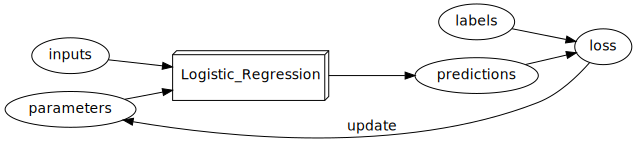

In [4]:
from fastbook import *
#For plotting our plan of Training the model
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=Logistic_Regression]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

## 1. Data

Downloading the data from PyTorch's default datasets module.  

In [7]:
from torchvision.datasets import MNIST
mnist_train = MNIST(root ="./", train=True, transform = transforms.ToTensor(), download=True) 
mnist_test = MNIST(root ="./", train=False, transform = transforms.ToTensor(), download=True)

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

HTTPError: HTTP Error 503: Service Unavailable

In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
#Labels(Targets) and Inputs
train_labels = train['label'].values
train_images = (train.iloc[:,1:].values).astype('float32')
test_images = (test.iloc[:,:].values).astype('float32')

In [7]:
#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=302,
                                                                     test_size=0.2)

In [11]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
#test
test_images_tensor = torch.tensor(test_images)/255.0

In [28]:
train_loader = DataLoader(train_tensor, batch_size = 100, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size = 100, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size = 100, shuffle=False)

In [29]:
#Training and Test data size
len(train_images_tensor), len(val_images_tensor), len(test_images_tensor)

(33600, 8400, 28000)

In [30]:
#Shape of an image
image = train_images[3,:]
print(image.shape)

(784,)


Image Label:  4


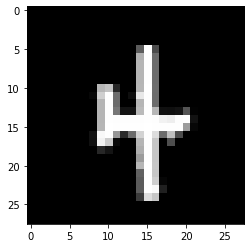

In [31]:
#Plotting an image
image = image.reshape([28,28])
plt.imshow(image, cmap = "gray")
print("Image Label: ", train_labels[3])

Preprocessing the data to in torch data loaders with batches.

In [32]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("Images shape: ", images.shape)
print("Lables shape: ", labels.shape)

Images shape:  torch.Size([100, 784])
Lables shape:  torch.Size([100])


In [33]:
#input shape after flattening the images 
x = images.view(-1, 28*28)
x.shape 

torch.Size([100, 784])

## 2. Model

This is rather very simple model. This does not involve anything 'deep'. On comparing it with neural networks we can consider neural networks as using logistic regression k-times with non-linear activation functions.  



Initializing the parameters: Weights(W) and Biases(b),

In [34]:
#weights and biases
W = torch.randn(784, 10)/np.sqrt(784)
b = torch.zeros(10, requires_grad=True)
W.requires_grad_()

tensor([[ 0.0216, -0.0075,  0.0117,  ..., -0.0160,  0.0081,  0.0153],
        [ 0.0016,  0.0255, -0.0754,  ...,  0.0706,  0.0639,  0.0086],
        [ 0.0176,  0.0053, -0.0115,  ..., -0.0213,  0.0019,  0.0020],
        ...,
        [ 0.0633, -0.0572,  0.0245,  ..., -0.0122, -0.0147, -0.0302],
        [-0.0141,  0.0168, -0.0588,  ..., -0.0074,  0.0074,  0.0232],
        [ 0.0150, -0.0070, -0.0149,  ...,  0.0367,  0.0271,  0.0274]],
       requires_grad=True)

The 'require_grad' is true so that both weights and biases are learned. This tells PyTorch's autograd to track gradients for these two variable and the variables depending on W and b.

## 3. Forward pass 
Forward Propagation is where we apply randomly initialized weights and biases. These parameters are the 'knobs' to tune our model for less loss and better prediction.

\begin{align}
Y = X W + b 
\end{align}


In [35]:
#Linear Transformation
y = torch.matmul(x, W) + b
y[0,:]

tensor([-0.0985,  0.1850, -0.3996,  0.0770, -0.3132, -0.2144,  0.3726,  0.6834,
        -0.0430, -0.0025], grad_fn=<SliceBackward>)

Following are the softmax implementaions that squash output of forward propagation 'y' into range of (0,1) by applying softmax activation function. This can be done by either hard-coding the softmax function or by using sotmax from the torch.nn.Functional module.

\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}

<Figure size 432x288 with 0 Axes>

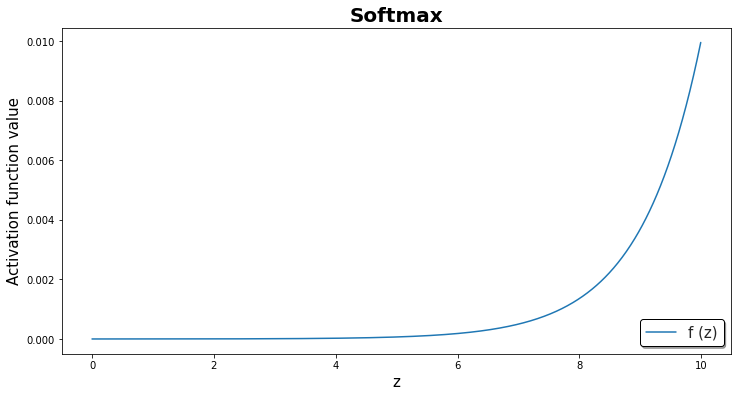

In [42]:
#Loss Function
def make_plot(x, f, name):
    plt.figure()
    plt.figure(figsize=(12,6))
    plt.title(name, fontsize=20, fontweight='bold')
    plt.xlabel('z', fontsize=15)
    plt.ylabel('Activation function value', fontsize=15)
    sns.set_style("whitegrid")
    plt.plot(x, f, label="f (z)")
    plt.legend(loc=4, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
    plt.savefig(name + ".png")
    plt.show()

z = np.arange(0, 10, 0.01)
f = np.exp(z)/sum(np.exp(z))
make_plot(z, f, "Softmax")

In [43]:
#Probability of classes function from scratch
prob_eqn = torch.exp(y)/torch.sum(torch.exp(y), dim=1, keepdim=True)
prob_eqn[0]

tensor([0.0840, 0.1116, 0.0622, 0.1001, 0.0678, 0.0748, 0.1346, 0.1836, 0.0888,
        0.0925], grad_fn=<SelectBackward>)

In [44]:
#Probability of classes using softmax
probs = F.softmax(y, dim=1)
probs[0]

tensor([0.0840, 0.1116, 0.0622, 0.1001, 0.0678, 0.0748, 0.1346, 0.1836, 0.0888,
        0.0925], grad_fn=<SelectBackward>)

In [45]:
#Viewing the shape of labels
labels.shape

torch.Size([100])

Loss Function/Cost Function- Cross Entropy which is suitable for multi-class classification tasks.

\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}


In [46]:
#Loss Function: Cross Entropy Loss
loss = F.cross_entropy(y, labels)
loss

tensor(2.3559, grad_fn=<NllLossBackward>)

## 4. Backprop

We have forward propagation and loss, now we need to update weights that is measured by penalising the models's output from forward propagation using loss function. The updating of weights while going backwards in the model is what we call training process. This updating of weights needs an updating rule or 'optimization function' like gradient functions. We will be using SGD- Stochastic Gradient Descent. 


\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

where $\theta$ is a parameter, $\alpha$ is our learning rate (step size), and $\nabla_\theta \mathcal{L}$ is the gradient of our loss with respect to $\theta$.

In [47]:
#Update Rule
optimizer = torch.optim.SGD([W,b], lr=0.1)

To compute the gradients for W and b we need to call the backward() finction on the cross entropy loss function(loss).

In [48]:
loss.backward()

Now the variables that required gradients have now accumulated gradients. For example,

In [49]:
b.grad

tensor([-0.0058,  0.0093,  0.0008, -0.0357, -0.0110, -0.0142, -0.0261,  0.0525,
         0.0184,  0.0117])

To apply gradient to update W and b we use the updation rule, i.e., our optimizer function. 

In [50]:
optimizer.step()

Our learning rate is 0.1 so b is now updated by -0.1*b.grad,

In [51]:
b

tensor([ 5.7676e-04, -9.3363e-04, -7.9736e-05,  3.5733e-03,  1.0987e-03,
         1.4150e-03,  2.6054e-03, -5.2479e-03, -1.8421e-03, -1.1659e-03],
       requires_grad=True)

We've now successfully trained on a minibatch! However, one minibatch probably isn't enough. At this point, we've trained the model on 100 examples out of the 60000 in the training set. We're going to need to repeat this process, for more of the data.

One more thing to keep in mind though: gradients calculated by backward() don't override the old values; instead, they accumulate. Therefore, we'll need to clear the gradient buffers before you compute gradients for the next minibatch.

In [52]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0058,  0.0093,  0.0008, -0.0357, -0.0110, -0.0142, -0.0261,  0.0525,
         0.0184,  0.0117])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


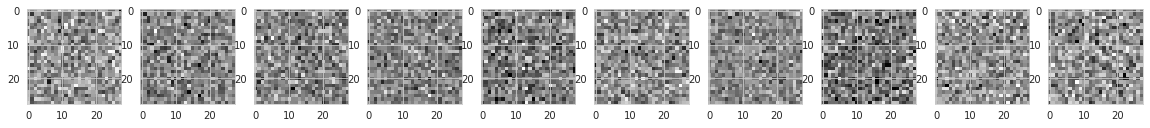

In [53]:
fig, ax = plt.subplots(1,10, figsize =(20,2))

for d in range(10):
    ax[d].imshow(W[:, d].detach().view(28,28), cmap='gray')

## 5. Training

In [54]:
for images, labels in tqdm(train_loader):
    optimizer.zero_grad() #Resetting the gradients to zero
    
    #Forward Propagation
    x = images.view(-1, 28*28) #Flattening the images
    y = torch.matmul(x, W) + b #Linear Transformation
    loss = F.cross_entropy(y, labels)

    #Back propagation
    loss.backward()
    optimizer.step()

  0%|          | 0/336 [00:00<?, ?it/s]

## 6. Testing

In [57]:
correct = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W)+b

        prediction = torch.argmax(y, dim=1)
        correct += torch.sum(prediction==labels).float()

  0%|          | 0/84 [00:00<?, ?it/s]

In [60]:
print('Validation Accuracy : {}'.format(100*(correct/len(val_images_tensor))) )

Validation Accuracy : 88.6785659790039


## 7. Plotting the learned weights

The following plots are what our logistic regression model has learned. These parameters are what our model 'sees' and classifies them into the classes of digits.

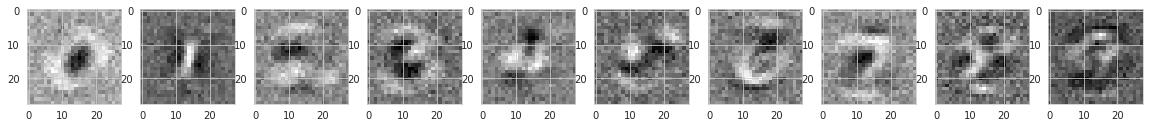

In [61]:
fig, ax = plt.subplots(1,10, figsize =(20,2))

for d in range(10):
    ax[d].imshow(W[:, d].detach().view(28,28), cmap='gray')

## Predictions

In [64]:
test_preds = torch.LongTensor()
for images in tqdm(test_loader):
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W)+b

    prediction = torch.argmax(y, dim=1)
    test_preds = torch.cat((test_preds, prediction), dim=0)

  0%|          | 0/280 [00:00<?, ?it/s]

In [66]:
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sub['Label'] = test_preds.numpy().squeeze()
sub.to_csv("results.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


# Thank you!

Author: [Pratik Kumar](https://pr2tik1.github.io)<br>
References: [fastai](https://www.fast.ai), [Coursera](https://coursera.org/share/ea5cc945df9fab563eb9bc9de3089eb9)